<h1 align='center'>Topic Modeling</h1>

In this notebook we explore two topic modeling algorithms, LSI and LDA, on the movie plots from IMDB and Wikipedia that we collected and processed
<hr>

In [66]:
%%bash
#conda update anaconda
#pip install pyldavis

In [230]:
import pandas as pd
import numpy as np
from gensim import corpora, models, similarities
import pickle
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO
from ast import literal_eval
import itertools
import pyLDAvis
import textblob as tb
import nltk
from nltk.stem import *
import slugify as sl
import pyLDAvis.gensim as gensimvis
import pyLDAvis
import random

In [238]:
dropbox_dir = "/Users/mr/Dropbox/moviemeta/"

## Document frequency

First we will make exploratory data analysis on our data. For this we take a sample from the processed IMDB plots

In [546]:
def iterdocs(filepath):
    '''iterate over documents from file'''
    for line in open (filepath):
        yield literal_eval(line)

In [494]:
sample_imdb_docs = random.sample(list(iterdocs(dropbox_dir + 'imdb_plots.list')), 10000)
sample_imdb_dict = corpora.Dictionary(sample_imdb_docs)
sample_imdb_corpus =[sample_imdb_dict.doc2bow(doc) for doc in sample_imdb_docs]
print 'Number of words in vocabulary of sample: ' + str(len(imdb_dict))

Number of words in vocabulary of sample: 41735


Let's take a look how the tokens in our sample are distributed over documents  

In [244]:
sample_imdb_dfs = sorted(sample_imdb_dict.dfs.items(), key=lambda x : x[1], reverse=True)
sample_imdb_words = [sample_imdb_dict[tup[0]] for tup in sample_imdb_dfs]
sample_imdb_dfcounts = [tup[1] for tup in sample_imdb_dfs]

<function matplotlib.pyplot.show>

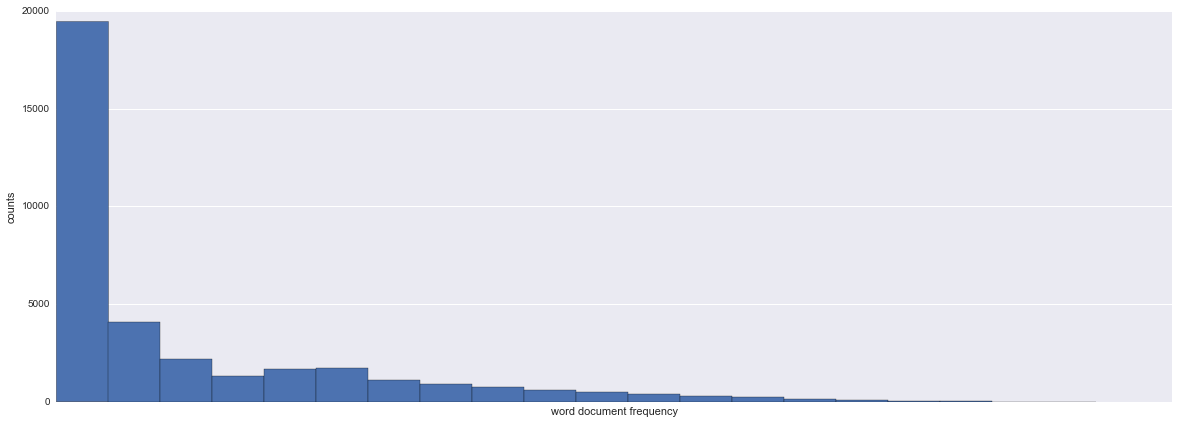

In [489]:
plt.figure(figsize=(20,7))
#bins = np.arange(0,12,0.2)
plt.hist(np.log2(sample_imdb_dfcounts),bins = 20, color=sns.color_palette()[0])
plt.xticks([])
plt.xlabel('word document frequency')
plt.ylabel('counts')
plt.show

We can observe a typical Zipf distribution of the words: There are a lot of words that occur in very few documents (almost half of the words a very rare), and a few very common words that occur in a lot of documents. Let's take a closer look at those common words as words which are very common but carry little meaning will distort our models. 

In [245]:
def plot_dfs(words, counts,top=True, num=25):
    if top == True:
        words = words[:num]
        counts = counts[:num]
    else:
        words = words[-num:]
        counts = counts[-num:]
    plt.figure(figsize=(20,7))
    plt.bar(range(num), counts, color=sns.color_palette()[0])
    plt.xticks(range(num),words)
    plt.show()

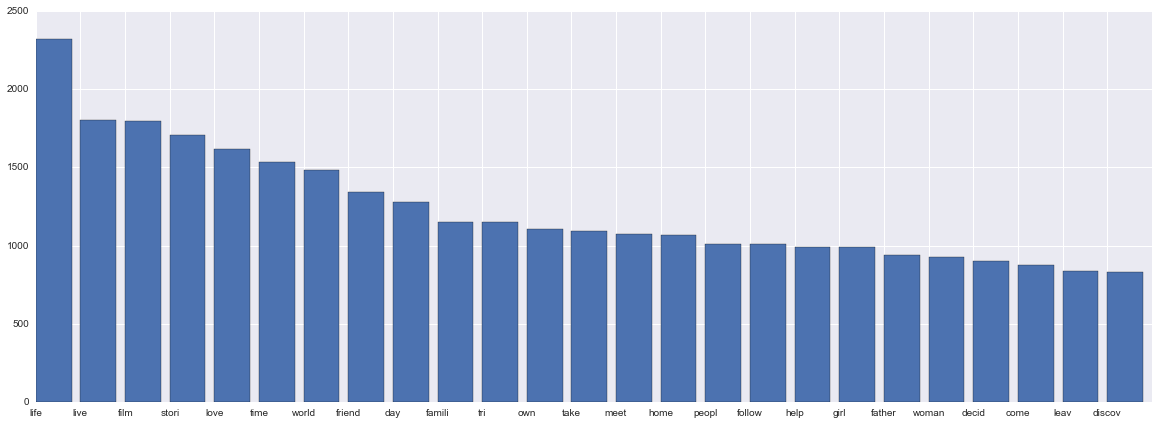

In [282]:
plot_dfs(sample_imdb_words, sample_imdb_dfcounts)

## Feature Engineering

There are some very common words in our data set that don't carry any meaning with respect to the themes of a movie. 
Words such as life, film, story etc will be present in a little of topics but won't capture any characteristics of a movie. We want to have as little meaningless words in our topics as possible so we will comprise of words to exclude from the corpus:

In [284]:
excludes = [u'life', u'stori', u'film', u'live', u'world', u'time',  u'day', u'own', u'peopl', u'follow', u'meet',
u'take', u'set', u'come', u'look', u'tell', u'call', u'name', u'bring', u'happen', u'soon', u'goe', u'littl']

We also don't want the names of characters mentioned in the plots to be present in the topics as we should avoid that movies are charactarised as similar due to the names of their characters. So we scraped a list of common English (http://behinddthename.com) and Indian (http://www.studentsoftheworld.info/penpals/stats.php3?Pays=IND) names from the web as theses most common nationalities in the data set.

In [285]:
common_names = []
for line in open(dropbox + 'names.txt'):
    common_names.append(line[:-1])
common_names = map(lambda x : PorterStemmer().stem(sl.slugify(x)), common_names)
excludes = excludes + common_names
len(excludes)

2222

Let's set up a new corpus from which we exclude common words and names. We will also use filter out those very rare words (words with a document count below 5). As these words don't really occurr across documents, it won't be possible to infer topic membership from them.

In [296]:
#filter out words with a df below 5
sample_imdb_dict.filter_extremes(no_below=5, no_above=1.0)
exclude_ids = []
for token in excludes:
    try:
        token_id = sample_imdb_dict.token2id[token]
        exclude_ids.append(token_id)
    except:
        pass
sample_imdb_dict.filter_tokens(exclude_ids)
corpus_cleaned =[sample_imdb_dict.doc2bow(doc) for doc in sample_imdb_docs]

INFO:gensim.corpora.dictionary:discarding 0 tokens: []...
INFO:gensim.corpora.dictionary:keeping 7625 tokens which were in no less than 5 and no more than 10000 (=100.0%) documents
INFO:gensim.corpora.dictionary:resulting dictionary: Dictionary(7625 unique tokens: [u'woodi', u'foul', u'scold', u'outwit', u'lord']...)


In [297]:
dfs_cleaned = sorted(sample_imdb_dict.dfs.items(), key=lambda x : x[1], reverse=True)
words_cleaned = [sample_imdb_dict[tup[0]] for tup in dfs_cleaned]
counts_cleaned = [tup[1] for tup in dfs_cleaned]

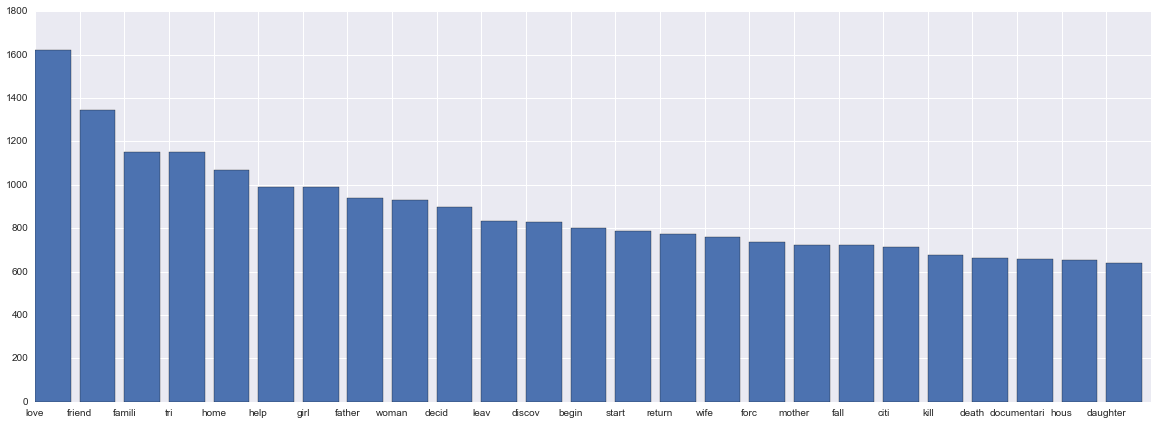

In [298]:
plot_dfs(words_cleaned, counts_cleaned)

After cleaning our corpus we now see words that carry some meaning as the most frequent across documents.

## LSI

The TFIDF measure is an important measure for the relevance of words across documents in natural language processing and information retrieval. It is the product of term frequency (TF) and inverse document frequency (IDF). A high TFIDF can be interpreted like this: A word is frequent, but not spread out over many documents (it is a characteristic word). A low TFIDF like this: A word is not so frequent, but occurrs in many documents (it is a generic word).

LSI computes sparse vectors for documents based on the TFIDF measure of its words and then uses singular value decomposition (SVD) identify topics and how terms in the corpus are associated to these topics.

In [495]:
tfidf = models.TfidfModel(corpus_cleaned)
corpus_tfidf = tfidf[corpus_cleaned]
lsi = models.LsiModel(corpus_tfidf, id2word=sample_imdb_dict, num_topics=20)
corpus_lsi = lsi[corpus_tfidf] 

In [300]:
lsi.print_topics(20)

INFO:gensim.models.lsimodel:topic #0(10.732): 0.136*"love" + 0.124*"famili" + 0.121*"friend" + 0.111*"girl" + 0.110*"father" + 0.100*"home" + 0.097*"tri" + 0.095*"woman" + 0.090*"mother" + 0.087*"wife"
INFO:gensim.models.lsimodel:topic #1(5.430): -0.226*"documentari" + -0.204*"music" + 0.149*"father" + -0.130*"featur" + -0.129*"interview" + 0.127*"marri" + -0.127*"explor" + 0.126*"wife" + 0.119*"daughter" + -0.118*"artist"
INFO:gensim.models.lsimodel:topic #2(4.681): -0.276*"murder" + 0.201*"love" + -0.196*"kill" + -0.196*"polic" + -0.166*"killer" + 0.164*"mother" + 0.161*"girl" + 0.142*"father" + 0.138*"famili" + -0.136*"investig"
INFO:gensim.models.lsimodel:topic #3(4.306): -0.277*"famili" + 0.214*"music" + -0.202*"war" + -0.167*"father" + -0.157*"mother" + -0.119*"human" + -0.118*"journey" + 0.110*"friend" + -0.108*"death" + 0.106*"danc"
INFO:gensim.models.lsimodel:topic #4(4.179): 0.192*"marri" + 0.192*"war" + 0.181*"famili" + -0.158*"murder" + -0.149*"mysteri" + 0.137*"music" + -0

[u'0.136*"love" + 0.124*"famili" + 0.121*"friend" + 0.111*"girl" + 0.110*"father" + 0.100*"home" + 0.097*"tri" + 0.095*"woman" + 0.090*"mother" + 0.087*"wife"',
 u'-0.226*"documentari" + -0.204*"music" + 0.149*"father" + -0.130*"featur" + -0.129*"interview" + 0.127*"marri" + -0.127*"explor" + 0.126*"wife" + 0.119*"daughter" + -0.118*"artist"',
 u'-0.276*"murder" + 0.201*"love" + -0.196*"kill" + -0.196*"polic" + -0.166*"killer" + 0.164*"mother" + 0.161*"girl" + 0.142*"father" + 0.138*"famili" + -0.136*"investig"',
 u'-0.277*"famili" + 0.214*"music" + -0.202*"war" + -0.167*"father" + -0.157*"mother" + -0.119*"human" + -0.118*"journey" + 0.110*"friend" + -0.108*"death" + 0.106*"danc"',
 u'0.192*"marri" + 0.192*"war" + 0.181*"famili" + -0.158*"murder" + -0.149*"mysteri" + 0.137*"music" + -0.135*"dream" + -0.132*"dark" + 0.131*"daughter" + 0.131*"brother"',
 u'-0.542*"school" + -0.276*"student" + 0.228*"woman" + -0.196*"boy" + -0.182*"girl" + -0.130*"teacher" + 0.128*"love" + 0.119*"wife" +

The topics are rather general and quite similar to each other. And there is another problem: Almost 90% of the documents have the first topic as their highest ranking topic (see below). This is not what we are looking for. We want to be able to characterise movies by their topics and be able to analyze the differences in topics over different dimensions.

In [325]:
def get_topic_doc_counts(corpus, numtopics):
    topics = range(numtopics)
    counts = [0] * numtopics
    topic_counts = dict(zip(topics,counts))
    for i,doc in enumerate(corpus):
        doc.sort(key=lambda x: x[1],reverse=True) 
        topic_counts[doc[0][0]] += 1
    return topic_counts

In [322]:
get_topic_doc_counts(corpus_lsi, 20)

{0: 8865,
 1: 2,
 2: 7,
 3: 115,
 4: 43,
 5: 12,
 6: 85,
 7: 34,
 8: 118,
 9: 68,
 10: 131,
 11: 109,
 12: 47,
 13: 39,
 14: 64,
 15: 25,
 16: 35,
 17: 51,
 18: 54,
 19: 96}

## LDA

LDA is a probabilistic generative model that assumes that documents are a mixture of topics. It uncovers these topics as collections of words that associated with a topic with a certain probability. For every document a vector of probabilities is computed that represents their membership in topics.

Let's set up a model that will find 20 topics in our corpus.

In [496]:
sample_imdb_lda = models.LdaModel(corpus_cleaned,id2word=sample_imdb_dict, num_topics=20)
sample_imdb_lda.save(dropbox_dir +'imdb_sample_lda.model')
sample_imdb_lda_corpus = sample_imdb_lda[corpus_cleaned]
corpora.MmCorpus.serialize(dropbox_dir + 'imdb_sample_lda.corpus', sample_imdb_lda_corpus)

In [317]:
sample_imdb_lda.show_topics(20)

[u'0.011*polic + 0.009*murder + 0.006*kill + 0.006*tri + 0.005*discov + 0.005*run + 0.005*investig + 0.005*father + 0.005*citi + 0.005*forc',
 u'0.011*girl + 0.010*marri + 0.009*love + 0.007*wife + 0.007*fall + 0.007*kill + 0.006*decid + 0.006*war + 0.006*leav + 0.005*friend',
 u'0.006*murder + 0.006*student + 0.005*colleg + 0.005*person + 0.005*help + 0.005*tri + 0.004*ghost + 0.004*outlaw + 0.004*school + 0.004*compani',
 u'0.010*love + 0.007*mother + 0.007*fall + 0.007*drug + 0.006*arriv + 0.006*help + 0.006*wife + 0.005*girl + 0.005*father + 0.005*friend',
 u'0.020*home + 0.012*father + 0.012*return + 0.008*famili + 0.008*mother + 0.007*friend + 0.006*wife + 0.006*start + 0.005*daughter + 0.005*leav',
 u'0.007*interview + 0.006*includ + 0.005*killer + 0.005*kill + 0.005*murder + 0.005*movi + 0.004*mysteri + 0.004*documentari + 0.004*human + 0.004*featur',
 u'0.008*famili + 0.007*team + 0.007*dream + 0.007*women + 0.004*success + 0.004*love + 0.004*friend + 0.004*fight + 0.004*perfe

In [326]:
get_topic_doc_counts(sample_imdb_lda_corpus, 20)

{0: 699,
 1: 695,
 2: 320,
 3: 260,
 4: 617,
 5: 651,
 6: 471,
 7: 572,
 8: 596,
 9: 690,
 10: 309,
 11: 397,
 12: 442,
 13: 645,
 14: 283,
 15: 352,
 16: 551,
 17: 270,
 18: 162,
 19: 1018}

We see that LDA has uncovered topics that carry much more meaning and are much more distinguishable than the LSI topics. The are also much more evenly distributed across the corpus.

In [519]:
for bow in itertools.islice(corpus_cleaned, 0, 10):
    topics = sample_imdb_lda.get_document_topics(bow)
    topics = sorted(topics, key = lambda tup:tup[1], reverse=True)
    print 'plot:'
    print " ".join([sample_imdb_dict[e[0]] for e in bow])
    print 'main topic:'
    print sample_imdb_lda.print_topic(topics[0][0])
    print "=========================================="

plot:
grove embark janitor race spunki hurtl journey toward cosmo star human save shot doctor adequ drake unpreced earth report compet
main topic:
0.010*love + 0.007*mother + 0.007*fall + 0.007*drug + 0.006*arriv + 0.006*help + 0.006*wife + 0.005*girl + 0.005*father + 0.005*friend
plot:
child rest achiev belief play rais honest estat dream american lament stamp admir sad game road childish vine understand butcher includ mix cross-dress lurk surround laughter guitar hardli function hill feel king cynic local
main topic:
0.010*love + 0.007*mother + 0.007*fall + 0.007*drug + 0.006*arriv + 0.006*help + 0.006*wife + 0.005*girl + 0.005*father + 0.005*friend
plot:
machin kitchen especi begin phd jump control futur flatmat stop build thrill physic student
main topic:
0.007*interview + 0.006*includ + 0.005*killer + 0.005*kill + 0.005*murder + 0.005*movi + 0.004*mysteri + 0.004*documentari + 0.004*human + 0.004*featur
plot:
hidden offer laundri unpredict boyfriend fame power dirti introduc tri s

There are a lot of very short plots and LDA has difficulties finding the right topics for these. Let's have a look a the distribution of plot length across the corpus.

In [364]:
def plot_len_histogram(plots, title):
    fig, axes = plt.subplots(figsize=(15, 10))
    plt.hist(map(lambda x: len(x), plots),bins=range(0, 1000, 25))
    plt.title(title)
    plt.xticks(range(0, 1000, 25))
    plt.xlabel("Plot length in characters")
    plt.ylabel("Frequency")

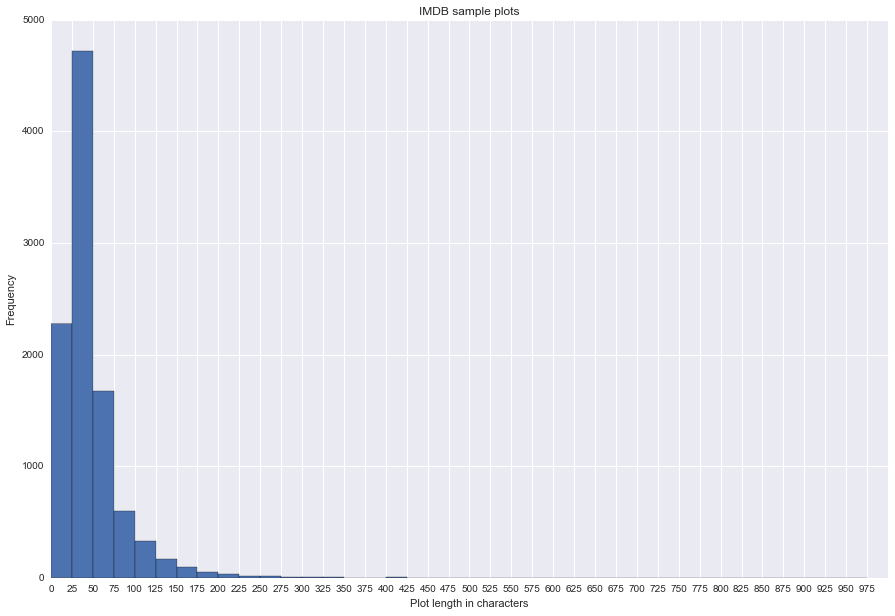

In [365]:
plot_len_histogram(imdb_docs_sample, 'IMDB sample plots')

## LDA model of IMDB plots

### Corpus

From the insight we have gained we construct a corpus class that:
* filters out short plots
* takes a list of words to exclude
* filters out very rare words

In [507]:
def iterdocs(filepath, min_len):
    for line in open (filepath):
        plot = literal_eval(line)
        if len(plot) >= min_len:
            yield plot
        
class Corpus(object):    
    def __init__(self, filename, excludes, min_len=25, dofilter=True):
        self.filepath = dropbox + filename
        self.min_len = min_len
        self.dictionary = corpora.Dictionary(iterdocs(self.filepath, self.min_len))
        if dofilter:
            #filter out the words with very low and very high document frequency
            self.dictionary.filter_extremes() 
        exclude_ids = []
        for token in excludes:
            try:
                token_id = self.dictionary.token2id[token]
                exclude_ids.append(token_id)
            except:
                pass
        self.dictionary.filter_tokens(exclude_ids)
    def __iter__(self):
        for doc in iterdocs(self.filepath, self.min_len):
            yield self.dictionary.doc2bow(doc)
    def documents(self):
        return list(self.dictionary.doc2bow(doc) for doc in iterdocs(self.filepath, self.min_len))

In [403]:
imdb_corpus = Corpus('imdb_plots.list', excludes)
corpora.MmCorpus.serialize(dropbox + 'lda_imdb.corpus', imdb_corpus)

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:adding document #10000 to Dictionary(38371 unique tokens: [u'fawn', u'min-je', u'fawk', u'long-sleev', u'woodi']...)
INFO:gensim.corpora.dictionary:adding document #20000 to Dictionary(58543 unique tokens: [u'fawn', u'min-je', u'circuitri', u'tirathyatra', u'fawk']...)
INFO:gensim.corpora.dictionary:adding document #30000 to Dictionary(73559 unique tokens: [u'fawn', u'min-je', u'circuitri', u'tirathyatra', u'fawk']...)
INFO:gensim.corpora.dictionary:adding document #40000 to Dictionary(87196 unique tokens: [u'fawn', u'min-je', u'circuitri', u'tirathyatra', u'fawk']...)
INFO:gensim.corpora.dictionary:adding document #50000 to Dictionary(100818 unique tokens: [u'fawn', u'circuitri', u'fawk', u'long-sleev', u'woodi']...)
INFO:gensim.corpora.dictionary:adding document #60000 to Dictionary(111857 unique tokens: [u'fawn', u'circuitri', u'fawk', u'long-sleev', u'woodi']...)
INFO

In [404]:
imdb_dict = imdb_corpus.dictionary
imdb_dict.save(dropbox + 'lda_imdb.dict')
imdb_dfs = sorted(imdb_dict.dfs.items(), key=lambda x : x[1], reverse=True)
imdb_words = [imdb_dict[tup[0]] for tup in imdb_dfs]
imdb_dfcounts = [tup[1] for tup in imdb_dfs]

INFO:gensim.utils:saving Dictionary object under /Users/mr/Dropbox/moviemeta/lda_imdb.dict, separately None


In [520]:
len(imdb_words)

41735

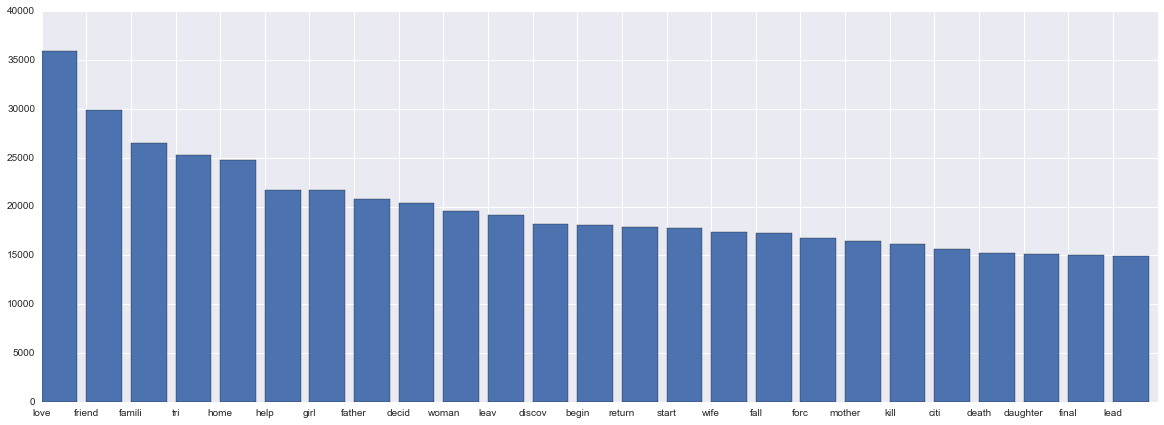

In [405]:
plot_dfs(imdb_words , imdb_dfcounts)

### Model

We fit an LDA model of thirty topics over the full IMDB corpus

In [498]:
imdb_lda = models.LdaModel(imdb_corpus,id2word=imdb_dict, num_topics=30)
imdb_lda.save(dropbox +'lda_imdb.model')

### Visualisation and Evaluation
We will visualize the LDA model with pyLDAvis. On the left you will see the topics in a 2d space that has been created using PCA dimensionality reduction. The sice of the circles corresponds two the prevalence of the topic in the corpus. The proximity of circles corresponds to semantic similarity of topics. On the right you see the words for the topics you select. The blue bar indicates the frequency of a word across the whole corpus, the red bar indicates how often it occurs in this topic. So the ratio of red to blue shows how characterestic a word is for a topic. By moving the relevance slider to the right you will see words that are particularly specific to this topic (generally very rare words).

In [416]:
vis_data = gensimvis.prepare(imdb_lda, imdb_corpus.documents(), imdb_dict)
pyLDAvibs.save_html(vis_data, dropbox + 'imdb_ldavis.html')
pyLDAvis.display(vis_data)

As LDA is an unsupervised algorithm we have no way of evaluation the result in an automated way.
But we can interpret what we see in the visualisation:
The topics are almost all very distinguishable and informative. The themes represented by the topics are what we would expect from a corpus of movie plots. The same goes for the order of topic relevance. 

The algorithm doesn't provide names for the topics so we will set these manually:

In [517]:
imdb_topic_labels ={0:'magic, myths',
                    1:'school, college',
                    2:'fantasy, christmas',
                    3:'home', 
                    4:'ships, sailing, pirates',
                    5:'love, relationships',
                    6:'war', 
                    7:'exploration, nature, space', 
                    8:'comedy',
                    9:'places, nature, scenery',
                    10:'hollywood, stars', 
                    11:'society, culture',
                    12:'historical, costumes', 
                    13:'money',
                    14:'photography, design',
                    15:'spies, terrorism', 
                    16:'mixed', 
                    17:'town',
                    18:'press, politics',
                    19:'crime, police, underworld',
                    20:'documentary, interview',
                    21:'friendship, relationships',
                    22:'cowboys and indians',
                    23:'night life, enjoyment',
                    24:'crime, mistery', 
                    25:'music',
                    26:'farming, country side',
                    27:'fantasy, fairy tale',
                    28:'love, family', 
                    29:'gangs, drug, police'}

In [518]:
for bow in itertools.islice(imdb_corpus, 0, 10):
    topics = imdb_lda.get_document_topics(bow)
    print 'plot:'
    print " ".join([imdb_dict[e[0]] for e in bow])
    topics = sorted(topics, key = lambda tup:tup[1], reverse=True)
    print 'topics:'
    for topic in topics:
        print imdb_lda.print_topic(topic[0])
        print imdb_topic_labels[topic[0]]
    print "=========================================="

plot:
rage hide quiet seeth surpris bloodi bundi outwardli polit forc killer combin racism reckon experienc mask histori idol complet violent reveal persona goal victim left serial
topics:
0.028*murder + 0.023*kill + 0.016*mysteri + 0.014*investig + 0.012*death + 0.012*dead + 0.011*discov + 0.011*killer + 0.009*secret + 0.009*detect
crime, mistery
0.017*american + 0.013*famili + 0.013*commun + 0.013*documentari + 0.012*cultur + 0.012*countri + 0.010*polit + 0.009*nation + 0.009*histori + 0.009*women
society, culture
0.019*love + 0.011*past + 0.011*woman + 0.010*relationship + 0.010*friend + 0.009*begin + 0.008*dream + 0.008*journey + 0.007*memori + 0.006*struggl
love, relationships
0.018*american + 0.015*japanes + 0.013*russian + 0.013*govern + 0.010*pilot + 0.009*bomb + 0.009*agent + 0.009*terrorist + 0.009*war + 0.009*japan
spies, terrorism
0.019*pictur + 0.017*anim + 0.010*imag + 0.009*color + 0.009*view + 0.008*sound + 0.008*short + 0.007*photograph + 0.007*camera + 0.007*motion
ph

## LDA model of Wikipedia plots

In [499]:
wiki_corpus = Corpus('wiki_plots_2000-2015.list', excludes)
corpora.MmCorpus.serialize(dropbox + 'lda_wiki.corpus', wiki_corpus)

wiki_dict = wiki_corpus.dictionary
wiki_dict.save(dropbox + 'lda_wiki.dict')
wiki_dfs = sorted(wiki_dict.dfs.items(), key=lambda x : x[1], reverse=True)
wiki_words = [wiki_dict[tup[0]] for tup in wiki_dfs]
wiki_dfcounts = [tup[1] for tup in wiki_dfs]

wiki_lda = models.LdaModel(wiki_corpus,id2word=wiki_dict, num_topics=30)
wiki_lda.save(dropbox +'lda_wiki.model')

In [192]:
wiki_vis_data = gensimvis.prepare(wiki_lda, wiki_corpus.documents(), wiki_dict)
pyLDAvis.save_html(wiki_vis_data, dropbox + 'wiki_ldavis.html')
pyLDAvis.display(wiki_vis_data)

We found the topics found in Wikipedia plots not quite as clear as the ones in IMDB. Wikipedia plots have higher word counts, but with IMDB we have much more data.

In [528]:
docs = imdb_corpus.documents()
movies = imdb_meta_df.title.values
index = similarities.MatrixSimilarity(imdb_lda[docs], num_features=30)

In [ ]:
def get_similar_movies(movie_plot):
    harry_vec = imdb_lda[harry]
    sims = sorted(enumerate(index[harry_vec]), key=lambda item: -item[1])
    for doc_sim in sims[:10]:
        print movies[doc_sim[0]] + " similarity:" + str(doc_sim[1])
        vec = docs[doc_sim[0]]
        for tup in vec:
            print imdb_dict.id2token[tup[0]]

In [531]:
harry = docs[86627]

harry_vec = imdb_lda[harry]
sims = sorted(enumerate(index[harry_vec]), key=lambda item: -item[1])
for doc_sim in sims[:10]:
    print movies[doc_sim[0]] + " similarity:" + str(doc_sim[1])
    vec = docs[doc_sim[0]]
    for tup in vec:
        print imdb_dict.id2token[tup[0]]

INFO:gensim.similarities.docsim:creating matrix with 199795 documents and 30 features


Harry Potter and the Order of the Phoenix (2007) similarity:1.0
porno
mazza
discov
transplant
squad
team
mosaic
drug
veteran
killer
lo
head
detect
eventu
citi
highli
cultur
vice
involv
femal
brother
york
elit
Teresa's Tattoo (1994) similarity:0.945758
death
kidnap
level
cash
tower
fight
variou
girlfriend
li
refus
scam
win
martial
wrap
unwittingli
top
watch
artist
hostag
thrown
bad
money
hold
option
Cherm (2005) similarity:0.943924
deal
hardcor
gang
score
action
race
drug
roughneck
hire
stop
nose
search
street
bullet
detect
person
talk
charact
close
friend
movi
begin
explos
hit
leader
crash
settl
Grand concours de la m�daille (1910) similarity:0.943136
wrong
train
special
deal
fuck
continu
one-lin
nevertheless
inform
dealer
team
action
suppos
drug
pursuit
cop
secret
increas
disturb
decid
interven
escap
investig
funni
bust
lowdown
gangster
unravel
assassin
reduc
die
upcom
weren
suspend
2035 (2016) similarity:0.942311
tomei
disintegr
disappear
deal
peterson
tour
tierra
drug
near
cop
fight

In [536]:
hunger = docs[212123]
vec = docs[86627]

(259028, 3)

In [547]:
excluded_plots = []
for i,doc in enumerate(iterdocs(dropbox_dir + 'imdb_plots.list')):
    if len(doc) < 25:
        excluded_plots.append(i)
    

In [552]:
imdb_meta_df = pd.read_csv(dropbox_dir + 'imdb_meta_df.csv')
imdb_meta_df_cleaned = imdb_meta_df.drop(excluded_plots)
imdb_meta_df_cleaned.to_csv(dropbox_dir + 'imdb_meta_df_cleaned.csv')